## CUDA 사용 가능여부 확인

In [1]:
import torch

if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 3080 Ti


C:\Users\louis\.conda\envs\practice\lib\site-packages\torch\cuda\__init__.py:143: UserWarning: 
NVIDIA GeForce RTX 3080 Ti with CUDA capability sm_86 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_61 sm_70 sm_75 compute_37.
If you want to use the NVIDIA GeForce RTX 3080 Ti GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


## 데이터 나누기

In [2]:
import os
import random
import numpy as np
import shutil

print(len(os.listdir('annotations')))
print(len(os.listdir('images')))

!mkdir test_images
!mkdir test_annotations


random.seed(1234)
idx = random.sample(range(853), 170)

for img in np.array(sorted(os.listdir('images')))[idx]:
    shutil.move('images/'+img, 'test_images/'+img)

for annot in np.array(sorted(os.listdir('annotations')))[idx]:
    shutil.move('annotations/'+annot, 'test_annotations/'+annot)

print(len(os.listdir('annotations')))
print(len(os.listdir('images')))
print(len(os.listdir('test_annotations')))
print(len(os.listdir('test_images')))

853
853
683
683
170
170


## 모델링에 필요한 패키지 로딩

In [3]:
import os
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from PIL import Image
import torchvision
from torchvision import transforms, datasets, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import time

C:\Users\louis\.conda\envs\practice\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\louis\.conda\envs\practice\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


## 바운딩 박스 정의

In [5]:
def generate_box(obj):
    
    xmin = float(obj.find('xmin').text)
    ymin = float(obj.find('ymin').text)
    xmax = float(obj.find('xmax').text)
    ymax = float(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

adjust_label = 1

def generate_label(obj):

    if obj.find('name').text == "with_mask":

        return 1 + adjust_label

    elif obj.find('name').text == "mask_weared_incorrect":

        return 2 + adjust_label

    return 0 + adjust_label

def generate_target(file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, "html.parser")
        objects = soup.find_all("object")

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))

        boxes = torch.as_tensor(boxes, dtype=torch.float32) 
        labels = torch.as_tensor(labels, dtype=torch.int64) 
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        return target

def plot_image_from_output(img, annotation):
    
    img = img.cpu().permute(1,2,0)
    
    fig,ax = plt.subplots(1)
    ax.imshow(img)
    
    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 1 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        
        elif annotation['labels'][idx] == 2 :
            
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')
            
        else :
        
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')

        ax.add_patch(rect)

    plt.show()

## 데이터셋 클래스 정의

In [6]:
class MaskDataset(object):
    def __init__(self, transforms, path):
        '''
        path: path to train folder or test folder
        '''
        # transform module과 img path 경로를 정의
        self.transforms = transforms
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))


    def __getitem__(self, idx): #special method
        # load images ad masks
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)
        
        if 'test' in self.path:
            label_path = os.path.join("test_annotations/", file_label)
        else:
            label_path = os.path.join("annotations/", file_label)

        img = Image.open(img_path).convert("RGB")
        #Generate Label
        target = generate_target(label_path)
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self): 
        return len(self.imgs)

data_transform = transforms.Compose([  # transforms.Compose : list 내의 작업을 연달아 할 수 있게 호출하는 클래스
        transforms.ToTensor() # ToTensor : numpy 이미지에서 torch 이미지로 변경
    ])

def collate_fn(batch):
    return tuple(zip(*batch))

dataset = MaskDataset(data_transform, 'images/')
test_dataset = MaskDataset(data_transform, 'test_images/')

data_loader = torch.utils.data.DataLoader(dataset, batch_size=4, collate_fn=collate_fn)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=2, collate_fn=collate_fn)

## 모델 불러오기

In [7]:
def get_model_instance_segmentation(num_classes):
  
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [8]:
model = get_model_instance_segmentation(4)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 
model.to(device)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to C:\Users\louis/.cache\torch\hub\checkpoints\fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 93.1MB/s] 


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

## 전이 학습

In [9]:
num_epochs = 10
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

In [10]:
print('----------------------train start--------------------------')
for epoch in range(num_epochs):
    start = time.time()
    model.train()
    i = 0    
    epoch_loss = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations) 
        losses = sum(loss for loss in loss_dict.values())        

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
        epoch_loss += losses
    print(f'epoch : {epoch+1}, Loss : {epoch_loss}, time : {time.time() - start}')

----------------------train start--------------------------


C:\Users\louis\.conda\envs\practice\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


epoch : 1, Loss : nan, time : 2683.3823385238647
epoch : 2, Loss : nan, time : 83.66764259338379
epoch : 3, Loss : nan, time : 83.74770450592041
epoch : 4, Loss : nan, time : 83.7146692276001
epoch : 5, Loss : nan, time : 83.72210383415222
epoch : 6, Loss : nan, time : 83.80372166633606
epoch : 7, Loss : nan, time : 83.67639017105103
epoch : 8, Loss : nan, time : 83.58447623252869
epoch : 9, Loss : nan, time : 83.64777421951294
epoch : 10, Loss : nan, time : 83.65237784385681


loss가 nan 값으로 나오네요.. 뭔가 이상합니다...

우선 가중치 저장

In [11]:
torch.save(model.state_dict(),f'model_{num_epochs}.pt')

In [12]:
model.load_state_dict(torch.load(f'model_{num_epochs}.pt'))

<All keys matched successfully>

## 바운딩 박스를 그리며 예측

In [14]:
def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)
    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold : 
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]

    return preds

In [15]:
with torch.no_grad(): 
    # 테스트셋 배치사이즈= 2
    for imgs, annotations in test_data_loader:
        imgs = list(img.to(device) for img in imgs)

        pred = make_prediction(model, imgs, 0.5)
        print(pred)
        break

[{'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}, {'boxes': tensor([], device='cuda:0', size=(0, 4)), 'labels': tensor([], device='cuda:0', dtype=torch.int64), 'scores': tensor([], device='cuda:0')}]


Target :  tensor([1, 1, 1, 2, 2, 1, 1, 1])


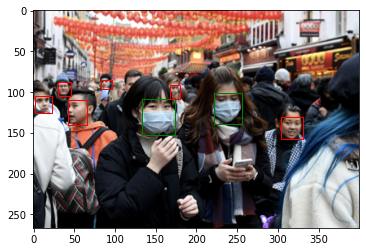

Prediction :  tensor([], device='cuda:0', dtype=torch.int64)


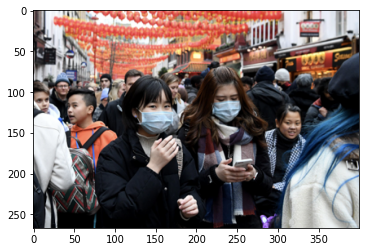

In [16]:
_idx = 1
print("Target : ", annotations[_idx]['labels'])
plot_image_from_output(imgs[_idx], annotations[_idx])
print("Prediction : ", pred[_idx]['labels'])
plot_image_from_output(imgs[_idx], pred[_idx])

역시 학습이 안됐네요...